<font size="+3">Time-series Generative Adversarial Network (TimeGAN)</font>

# Imports & Settings

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
from pathlib import Path
from tqdm import tqdm

from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import GRU, Dense, RNN, GRUCell, Input
from tensorflow.keras.losses import BinaryCrossentropy, MeanSquaredError
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras.utils import plot_model

import matplotlib.pyplot as plt
import seaborn as sns

2024-02-07 19:44:50.468025: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-02-07 19:44:50.516789: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-02-07 19:44:50.516824: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-02-07 19:44:50.518019: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-02-07 19:44:50.526765: I tensorflow/core/platform/cpu_feature_guar

In [4]:
gpu_devices = tf.config.experimental.list_physical_devices('GPU')
if gpu_devices:
    print('Using GPU')
    tf.config.experimental.set_memory_growth(gpu_devices[0], True)
else:
    print('Using CPU')

Using CPU


In [5]:
sns.set_style('white')

In [6]:
np.random.seed(42)
tf.random.set_seed(1234)

## Experiment Path

In [7]:
results_path = Path('time_gan')
if not results_path.exists():
    results_path.mkdir()

In [8]:
experiment = 0

In [9]:
log_dir = results_path / f'experiment_{experiment:02}'
if not log_dir.exists():
    log_dir.mkdir(parents=True)

In [10]:
hdf_store = results_path / 'TimeSeriesGAN.h5'

# TimeGAN Architecture and Training

# Prepare Data

The authors demonstrate the applicability of TimeGAN to financial data using 15 years of daily Google stock prices downloaded from Yahoo Finance with six features, namely open, high, low, close and adjusted close price, and volume. We’ll use instead close to 20 years of adjusted close prices for six different tickers because it introduces somewhat higher variability. We follow the original paper in targeting synthetic series with 24 time steps. 

In [11]:
df = pd.read_csv('../statapp-hsbc/data/GANData.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 36540 entries, 0 to 36539
Data columns (total 7 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   ASSETTYPE       36540 non-null  object 
 1   ASSETSUBTYPE    36540 non-null  object 
 2   ASSETNAME       36540 non-null  object 
 3   ISHEDGED        36540 non-null  bool   
 4   INDEXPROXYNAME  36540 non-null  object 
 5   VALUEDATE       36540 non-null  int64  
 6   PRICE           36540 non-null  float64
dtypes: bool(1), float64(1), int64(1), object(4)
memory usage: 1.7+ MB


## Parameters

In [12]:
seq_len = 24
n_seq = 1
batch_size = 128

In [13]:
tickers = [i for i in df.ASSETNAME.unique()]
print(len(tickers))
print(tickers)

16
['Global Property USD Unhedged', 'Infrastructure Debt - USD Unhedged', 'Global Government Bond USD Hedged', 'UK Government Bond - USD Hedged', 'US Government Bond USD Unhedged', 'Europe ex UK Equity - USD Unhedged', 'UK Equity - USD Unhedged', 'US Equity USD Unhedged', 'Liquidity EUR Unhedged in USD', 'Liquidity GBP Unhedged in USD', 'Liquidity USD Unhedged', 'EUR Corporate Bond - USD Hedged', 'Euro High Yield Bond BB-B - USD Hedged', 'GBP Corporate Bond - USD Hedged', 'US High Yield Bond - USD Unhedged', 'USD Corporate Bond - USD Unhedged']


## Plot Series

Among the stocks with the longest history in the Quandl Wiki dataset are those displayed in normalized format, i.e., starting at 1.0, in the following Figure 21.5. We retrieve the adjusted close from 2000-2017 and obtain over 4,000 observations. The correlation coefficient among the series ranges from 0.01 for GE and CAT. to 0.94 for DIS and KO.

In [14]:
from utils.network import *
from utils.create_data import *
from utils.data import Data

In [15]:
pivot_df = df.pivot_table(index='VALUEDATE', columns='ASSETNAME', values='PRICE').reset_index()


In [16]:
pivot_df

ASSETNAME,VALUEDATE,EUR Corporate Bond - USD Hedged,Euro High Yield Bond BB-B - USD Hedged,Europe ex UK Equity - USD Unhedged,GBP Corporate Bond - USD Hedged,Global Government Bond USD Hedged,Global Property USD Unhedged,Infrastructure Debt - USD Unhedged,Liquidity EUR Unhedged in USD,Liquidity GBP Unhedged in USD,Liquidity USD Unhedged,UK Equity - USD Unhedged,UK Government Bond - USD Hedged,US Equity USD Unhedged,US Government Bond USD Unhedged,US High Yield Bond - USD Unhedged,USD Corporate Bond - USD Unhedged
0,35853,NaN,NaN,3343.142000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,35854,124.022,105.701,3343.142000,NaN,332.1846,NaN,NaN,NaN,NaN,145.464901,4151.048000,102.262869,2946.083000,241.530000,NaN,949.244263
2,35885,124.730,106.964,3610.708000,NaN,334.4977,NaN,NaN,NaN,NaN,146.135886,4370.304000,104.112292,3099.360000,242.190000,NaN,952.750061
3,35915,124.940,109.238,3709.847000,NaN,336.1632,NaN,NaN,NaN,NaN,146.872656,4379.814000,105.039546,3136.193000,243.270000,NaN,958.766296
4,35944,NaN,NaN,3878.258000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2617,45160,365.741,455.961,13779.223853,312.383430,844.5036,5091.385814,NaN,NaN,NaN,120.416750,9868.529302,253.346038,19537.023755,580.271813,490.214,2992.667990
2618,45161,367.725,456.467,13833.668180,315.354005,850.3725,5167.731061,NaN,NaN,NaN,NaN,9894.270122,257.123708,19756.605945,584.867544,492.373,3025.278091
2619,45169,NaN,NaN,NaN,NaN,NaN,NaN,2263.99,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2620,45199,NaN,NaN,NaN,NaN,NaN,NaN,2255.04,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [17]:
for i in tickers : 
    print(len(df[df["ASSETNAME"] == i]))


2507
224
2503
2495
2439
2572
2514
2519
2085
1899
2483
2528
2528
2483
2332
2429


In [18]:
df_asset_1 = df[df["ASSETNAME"] == tickers[0]]
df_asset_1.head()

,ASSETTYPE,ASSETSUBTYPE,ASSETNAME,ISHEDGED,INDEXPROXYNAME,VALUEDATE,PRICE
0,Alternative,Property,Global Property USD Unhedged,False,FTSE Russell FTSE EPRA Nareit Developed Index ...,36219,889.64
1,Alternative,Property,Global Property USD Unhedged,False,FTSE Russell FTSE EPRA Nareit Developed Index ...,36250,916.07
2,Alternative,Property,Global Property USD Unhedged,False,FTSE Russell FTSE EPRA Nareit Developed Index ...,36280,1006.43
3,Alternative,Property,Global Property USD Unhedged,False,FTSE Russell FTSE EPRA Nareit Developed Index ...,36311,983.72
4,Alternative,Property,Global Property USD Unhedged,False,FTSE Russell FTSE EPRA Nareit Developed Index ...,36341,1005.67


In [19]:
df_asset_1 = df_asset_1.pivot_table(index='VALUEDATE', columns='ASSETNAME', values='PRICE').reset_index()
df_asset_1.head()

ASSETNAME,VALUEDATE,Global Property USD Unhedged
0,36219,889.64
1,36250,916.07
2,36280,1006.43
3,36311,983.72
4,36341,1005.67


In [20]:
df_asset_1.drop(columns =["VALUEDATE"], inplace = True)

In [21]:
df_asset_1

ASSETNAME,Global Property USD Unhedged
0,889.640000
1,916.070000
2,1006.430000
3,983.720000
4,1005.670000
...,...
2502,5124.047938
2503,5116.900747
2504,5063.070159
2505,5091.385814


In [22]:
df_asset_1['Global Property USD Unhedged'] = df_asset_1['Global Property USD Unhedged'].div(df_asset_1['Global Property USD Unhedged'].iloc[0])

In [23]:
df_asset_1

ASSETNAME,Global Property USD Unhedged
0,1.000000
1,1.029709
2,1.131278
3,1.105751
4,1.130424
...,...
2502,5.759687
2503,5.751653
2504,5.691145
2505,5.722973


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


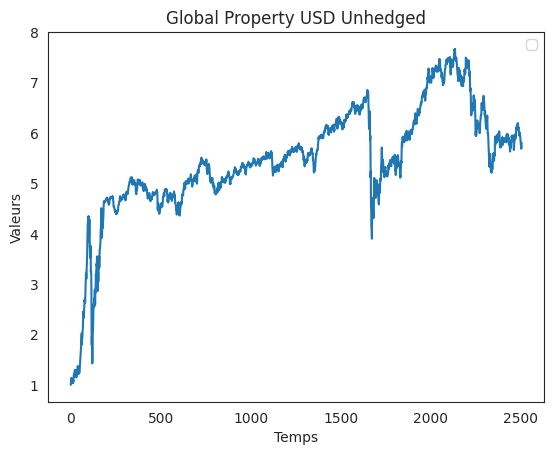

In [24]:
simple_plot(df_asset_1['Global Property USD Unhedged'], "Global Property USD Unhedged")

## Normalize Data

We scale each series to the range [0, 1] using scikit-learn’s `MinMaxScaler` that we later use to rescale the synthetic data.

In [25]:
scaler = MinMaxScaler()
scaled_df_asset1 = scaler.fit_transform(df_asset_1).astype(np.float32)

## Create rolling window sequences

In the next step, we create rolling windows containing overlapping sequences of 24 consecutive data points for the six series:

In [26]:
data = []
for i in range(len(df_asset_1) - seq_len):
    data.append(scaled_df_asset1[i:i + seq_len])

n_windows = len(data)

## Create tf.data.Dataset

In [27]:
real_series = (tf.data.Dataset
               .from_tensor_slices(data)
               .shuffle(buffer_size=n_windows)
               .batch(batch_size))
real_series_iter = iter(real_series.repeat())

In [28]:
print(real_series)

<_BatchDataset element_spec=TensorSpec(shape=(None, 24, 1), dtype=tf.float32, name=None)>


In [29]:
print(real_series_iter)

## Set up random series generator

We also need a random time series generator that produces simulated data with 24 observations on the six series as long as the training continues.

To this end, we create a generator that draws the requisite data uniform at random and feed the result into a second `tf.data.Dataset`. We set this `Dataset` to produce batches of the desired size and to repeat the process as long as necessary:

In [30]:
def make_random_data():
    while True:
        yield np.random.uniform(low=0, high=1, size=(seq_len, n_seq))

We use the Python generator to feed a `tf.data.Dataset` that continues to call the random number generator as long as necessary and produces the desired batch size.

In [31]:
random_series = iter(tf.data.Dataset
                     .from_generator(make_random_data, output_types=tf.float32)
                     .batch(batch_size)
                     .repeat())

# TimeGAN Setup

We’ll now create the two autoencoder components and the two adversarial network elements, as well as the supervisor that encourages the generator to learn the temporal dynamic of the historical price series.

##  Network Parameters

We follow the authors’ sample code in creating RNNs with three hidden layers with 24 GRU units each, except for the supervisor that only uses two hidden layers.

In [32]:
hidden_dim = 24
num_layers = 3

## Set up logger

In [33]:
writer = tf.summary.create_file_writer(log_dir.as_posix())

## Input place holders

In [34]:
X = Input(shape=[seq_len, n_seq], name='RealData')
Z = Input(shape=[seq_len, n_seq], name='RandomData')

## RNN block generator

We keep it simple and use a very similar architecture for all four components. For a real-world application, they should be tailored to the data.

The following `make_rnn` function automates the network creation:

In [35]:
def make_rnn(n_layers, hidden_units, output_units, name):
    return Sequential([GRU(units=hidden_units,
                           return_sequences=True,
                           name=f'GRU_{i + 1}') for i in range(n_layers)] +
                      [Dense(units=output_units,
                             activation='sigmoid',
                             name='OUT')], name=name)

## Embedder & Recovery

The autoencoder consists of the embedder and the recovery networks that we instantiate here:

In [36]:
embedder = make_rnn(n_layers=3, 
                    hidden_units=hidden_dim, 
                    output_units=hidden_dim, 
                    name='Embedder')
recovery = make_rnn(n_layers=3, 
                    hidden_units=hidden_dim, 
                    output_units=n_seq, 
                    name='Recovery')

## Generator & Discriminator

We then create the generator, the discriminator, and the supervisor like so:

In [37]:
generator = make_rnn(n_layers=3, 
                     hidden_units=hidden_dim, 
                     output_units=hidden_dim, 
                     name='Generator')
discriminator = make_rnn(n_layers=3, 
                         hidden_units=hidden_dim, 
                         output_units=1, 
                         name='Discriminator')
supervisor = make_rnn(n_layers=2, 
                      hidden_units=hidden_dim, 
                      output_units=hidden_dim, 
                      name='Supervisor')

# TimeGAN Training

## Settings

In [38]:
train_steps = 10000
gamma = 1

## Generic Loss Functions

We also define two generic loss functions, namely `MeanSquaredError` and `BinaryCrossEntropy` that we will use later to create the various specific loss functions during the three phases:

In [39]:
mse = MeanSquaredError()
bce = BinaryCrossentropy()

# Phase 1: Autoencoder Training

## Architecture

The autoencoder integrates the embedder and the recovery functions:

In [40]:
H = embedder(X)
X_tilde = recovery(H)

autoencoder = Model(inputs=X,
                    outputs=X_tilde,
                    name='Autoencoder')

In [41]:
autoencoder.summary()

Model: "Autoencoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 RealData (InputLayer)       [(None, 24, 1)]           0         
                                                                 
 Embedder (Sequential)       (None, 24, 24)            9744      
                                                                 
 Recovery (Sequential)       (None, 24, 1)             10825     
                                                                 
Total params: 20569 (80.35 KB)
Trainable params: 20569 (80.35 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


We next instantiate the optimizer for this training phase and define the training step. It follows the pattern introduced with the DCGAN example, using tf.GradientTape to record the operations that generate the reconstruction loss. This allows us to rely on the automatic differentiation engine to obtain the gradients with respect to the trainable embedder and recovery network weights that drive backpropagation:

## Autoencoder Optimizer

In [42]:
autoencoder_optimizer = Adam()

## Autoencoder Training Step

In [43]:
@tf.function
def train_autoencoder_init(x):
    with tf.GradientTape() as tape:
        x_tilde = autoencoder(x)
        embedding_loss_t0 = mse(x, x_tilde)
        e_loss_0 = 10 * tf.sqrt(embedding_loss_t0)

    var_list = embedder.trainable_variables + recovery.trainable_variables
    gradients = tape.gradient(e_loss_0, var_list)
    autoencoder_optimizer.apply_gradients(zip(gradients, var_list))
    return tf.sqrt(embedding_loss_t0)

## Autoencoder Training Loop

The reconstruction loss simply compares the autoencoder outputs with its inputs. We train for 10,000 steps in a little over one minute using this training loop that records the step loss for monitoring with TensorBoard:

In [44]:
for step in tqdm(range(train_steps)):
    X_ = next(real_series_iter)
    step_e_loss_t0 = train_autoencoder_init(X_)
    with writer.as_default():
        tf.summary.scalar('Loss Autoencoder Init', step_e_loss_t0, step=step)

100%|██████████| 10000/10000 [10:40<00:00, 15.61it/s]


## Persist model

In [45]:
autoencoder.save(log_dir / 'autoencoder')

INFO:tensorflow:Assets written to: time_gan/experiment_00/autoencoder/assets


INFO:tensorflow:Assets written to: time_gan/experiment_00/autoencoder/assets


# Phase 2: Supervised training

We already created the supervisor model so we just need to instantiate the optimizer and define the train step as follows:

## Define Optimizer

In [46]:
supervisor_optimizer = Adam()

## Train Step

In [47]:
@tf.function
def train_supervisor(x):
    with tf.GradientTape() as tape:
        h = embedder(x)
        h_hat_supervised = supervisor(h)
        g_loss_s = mse(h[:, 1:, :], h_hat_supervised[:, 1:, :])

    var_list = supervisor.trainable_variables
    gradients = tape.gradient(g_loss_s, var_list)
    supervisor_optimizer.apply_gradients(zip(gradients, var_list))
    return g_loss_s

In this case, the loss compares the output of the supervisor with the next timestep for the embedded sequence so that it learns the temporal dynamics of the historical price sequences; the training loop works similarly to the autoencoder example.

## Training Loop

In [48]:
for step in tqdm(range(train_steps)):
    X_ = next(real_series_iter)
    step_g_loss_s = train_supervisor(X_)
    with writer.as_default():
        tf.summary.scalar('Loss Generator Supervised Init', step_g_loss_s, step=step)

100%|██████████| 10000/10000 [06:52<00:00, 24.26it/s]


## Persist Model

In [49]:
supervisor.save(log_dir / 'supervisor')

INFO:tensorflow:Assets written to: time_gan/experiment_00/supervisor/assets


INFO:tensorflow:Assets written to: time_gan/experiment_00/supervisor/assets


# Joint Training

The joint training involves all four network components as well as the supervisor. It uses multiple loss functions and combinations of the base components to achieve the simultaneous learning of latent space embeddings, transition dynamics, and synthetic data generation. 

## Generator

### Adversarial Architecture - Supervised

In [50]:
E_hat = generator(Z)
H_hat = supervisor(E_hat)
Y_fake = discriminator(H_hat)

adversarial_supervised = Model(inputs=Z,
                               outputs=Y_fake,
                               name='AdversarialNetSupervised')

In [51]:
adversarial_supervised.summary()

Model: "AdversarialNetSupervised"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 RandomData (InputLayer)     [(None, 24, 1)]           0         
                                                                 
 Generator (Sequential)      (None, 24, 24)            9744      
                                                                 
 Supervisor (Sequential)     (None, 24, 24)            7800      
                                                                 
 Discriminator (Sequential)  (None, 24, 1)             10825     
                                                                 
Total params: 28369 (110.82 KB)
Trainable params: 28369 (110.82 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [52]:
plot_model(adversarial_supervised, show_shapes=True)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


### Adversarial Architecture in Latent Space

In [53]:
Y_fake_e = discriminator(E_hat)

adversarial_emb = Model(inputs=Z,
                    outputs=Y_fake_e,
                    name='AdversarialNet')

In [54]:
adversarial_emb.summary()

Model: "AdversarialNet"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 RandomData (InputLayer)     [(None, 24, 1)]           0         
                                                                 
 Generator (Sequential)      (None, 24, 24)            9744      
                                                                 
 Discriminator (Sequential)  (None, 24, 1)             10825     
                                                                 
Total params: 20569 (80.35 KB)
Trainable params: 20569 (80.35 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [55]:
plot_model(adversarial_emb, show_shapes=True)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


### Mean & Variance Loss

To ensure that the generator faithfully reproduces the time series, TimeGAN includes a moment loss that penalizes when mean and variance of the synthetic data deviate from the real version:

In [56]:
X_hat = recovery(H_hat)
synthetic_data = Model(inputs=Z,
                       outputs=X_hat,
                       name='SyntheticData')

The end-to-end model that produces synthetic data involves the generator, supervisor, and recovery component. It is defined as follows and has close to 30,000 trainable paramters:

In [57]:
synthetic_data.summary()

Model: "SyntheticData"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 RandomData (InputLayer)     [(None, 24, 1)]           0         
                                                                 
 Generator (Sequential)      (None, 24, 24)            9744      
                                                                 
 Supervisor (Sequential)     (None, 24, 24)            7800      
                                                                 
 Recovery (Sequential)       (None, 24, 1)             10825     
                                                                 
Total params: 28369 (110.82 KB)
Trainable params: 28369 (110.82 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [58]:
plot_model(synthetic_data, show_shapes=True)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


In [59]:
def get_generator_moment_loss(y_true, y_pred):
    y_true_mean, y_true_var = tf.nn.moments(x=y_true, axes=[0])
    y_pred_mean, y_pred_var = tf.nn.moments(x=y_pred, axes=[0])
    g_loss_mean = tf.reduce_mean(tf.abs(y_true_mean - y_pred_mean))
    g_loss_var = tf.reduce_mean(tf.abs(tf.sqrt(y_true_var + 1e-6) - tf.sqrt(y_pred_var + 1e-6)))
    return g_loss_mean + g_loss_var

## Discriminator

### Architecture: Real Data

In [60]:
Y_real = discriminator(H)
discriminator_model = Model(inputs=X,
                            outputs=Y_real,
                            name='DiscriminatorReal')

In [61]:
discriminator_model.summary()

Model: "DiscriminatorReal"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 RealData (InputLayer)       [(None, 24, 1)]           0         
                                                                 
 Embedder (Sequential)       (None, 24, 24)            9744      
                                                                 
 Discriminator (Sequential)  (None, 24, 1)             10825     
                                                                 
Total params: 20569 (80.35 KB)
Trainable params: 20569 (80.35 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [62]:
plot_model(discriminator_model, show_shapes=True)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


## Optimizers

The joint training involves three optimizers for the autoencoder, the generator and the discriminator:

In [63]:
generator_optimizer = Adam()
discriminator_optimizer = Adam()
embedding_optimizer = Adam()

## Generator Train Step

The train step for the generator illustrates the use of four loss functions and corresponding combinations of network components to achieve the desired learning outlined at the beginning of this section:

In [64]:
@tf.function
def train_generator(x, z):
    with tf.GradientTape() as tape:
        y_fake = adversarial_supervised(z)
        generator_loss_unsupervised = bce(y_true=tf.ones_like(y_fake),
                                          y_pred=y_fake)

        y_fake_e = adversarial_emb(z)
        generator_loss_unsupervised_e = bce(y_true=tf.ones_like(y_fake_e),
                                            y_pred=y_fake_e)
        h = embedder(x)
        h_hat_supervised = supervisor(h)
        generator_loss_supervised = mse(h[:, 1:, :], h_hat_supervised[:, 1:, :])

        x_hat = synthetic_data(z)
        generator_moment_loss = get_generator_moment_loss(x, x_hat)

        generator_loss = (generator_loss_unsupervised +
                          generator_loss_unsupervised_e +
                          100 * tf.sqrt(generator_loss_supervised) +
                          100 * generator_moment_loss)

    var_list = generator.trainable_variables + supervisor.trainable_variables
    gradients = tape.gradient(generator_loss, var_list)
    generator_optimizer.apply_gradients(zip(gradients, var_list))
    return generator_loss_unsupervised, generator_loss_supervised, generator_moment_loss

## Embedding Train Step

In [65]:
@tf.function
def train_embedder(x):
    with tf.GradientTape() as tape:
        h = embedder(x)
        h_hat_supervised = supervisor(h)
        generator_loss_supervised = mse(h[:, 1:, :], h_hat_supervised[:, 1:, :])

        x_tilde = autoencoder(x)
        embedding_loss_t0 = mse(x, x_tilde)
        e_loss = 10 * tf.sqrt(embedding_loss_t0) + 0.1 * generator_loss_supervised

    var_list = embedder.trainable_variables + recovery.trainable_variables
    gradients = tape.gradient(e_loss, var_list)
    embedding_optimizer.apply_gradients(zip(gradients, var_list))
    return tf.sqrt(embedding_loss_t0)

## Discriminator Train Step

In [66]:
@tf.function
def get_discriminator_loss(x, z):
    y_real = discriminator_model(x)
    discriminator_loss_real = bce(y_true=tf.ones_like(y_real),
                                  y_pred=y_real)

    y_fake = adversarial_supervised(z)
    discriminator_loss_fake = bce(y_true=tf.zeros_like(y_fake),
                                  y_pred=y_fake)

    y_fake_e = adversarial_emb(z)
    discriminator_loss_fake_e = bce(y_true=tf.zeros_like(y_fake_e),
                                    y_pred=y_fake_e)
    return (discriminator_loss_real +
            discriminator_loss_fake +
            gamma * discriminator_loss_fake_e)

In [67]:
@tf.function
def train_discriminator(x, z):
    with tf.GradientTape() as tape:
        discriminator_loss = get_discriminator_loss(x, z)

    var_list = discriminator.trainable_variables
    gradients = tape.gradient(discriminator_loss, var_list)
    discriminator_optimizer.apply_gradients(zip(gradients, var_list))
    return discriminator_loss

## Training Loop

Finally, the joint training loop pulls the various training steps together and builds on the learning from phase 1 and 2 to train the TimeGAN components on both real and random data. We run the loop for 10,000 iterations in under 50 minutes:

In [68]:
step_g_loss_u = step_g_loss_s = step_g_loss_v = step_e_loss_t0 = step_d_loss = 0
for step in range(train_steps):
    # Train generator (twice as often as discriminator)
    for kk in range(2):
        X_ = next(real_series_iter)
        Z_ = next(random_series)

        # Train generator
        step_g_loss_u, step_g_loss_s, step_g_loss_v = train_generator(X_, Z_)
        # Train embedder
        step_e_loss_t0 = train_embedder(X_)

    X_ = next(real_series_iter)
    Z_ = next(random_series)
    step_d_loss = get_discriminator_loss(X_, Z_)
    if step_d_loss > 0.15:
        step_d_loss = train_discriminator(X_, Z_)

    if step % 1000 == 0:
        print(f'{step:6,.0f} | d_loss: {step_d_loss:6.4f} | g_loss_u: {step_g_loss_u:6.4f} | '
              f'g_loss_s: {step_g_loss_s:6.4f} | g_loss_v: {step_g_loss_v:6.4f} | e_loss_t0: {step_e_loss_t0:6.4f}')

    with writer.as_default():
        tf.summary.scalar('G Loss S', step_g_loss_s, step=step)
        tf.summary.scalar('G Loss U', step_g_loss_u, step=step)
        tf.summary.scalar('G Loss V', step_g_loss_v, step=step)
        tf.summary.scalar('E Loss T0', step_e_loss_t0, step=step)
        tf.summary.scalar('D Loss', step_d_loss, step=step)

     0 | d_loss: 2.0444 | g_loss_u: 0.7421 | g_loss_s: 0.0005 | g_loss_v: 0.1637 | e_loss_t0: 0.0467
 1,000 | d_loss: 1.4722 | g_loss_u: 1.1013 | g_loss_s: 0.0001 | g_loss_v: 0.0528 | e_loss_t0: 0.0034
 2,000 | d_loss: 1.8890 | g_loss_u: 1.2172 | g_loss_s: 0.0000 | g_loss_v: 0.0532 | e_loss_t0: 0.0024
 3,000 | d_loss: 1.7324 | g_loss_u: 1.1728 | g_loss_s: 0.0001 | g_loss_v: 0.0283 | e_loss_t0: 0.0015
 4,000 | d_loss: 1.5976 | g_loss_u: 1.5581 | g_loss_s: 0.0001 | g_loss_v: 0.0392 | e_loss_t0: 0.0022
 5,000 | d_loss: 1.6282 | g_loss_u: 1.2787 | g_loss_s: 0.0003 | g_loss_v: 0.0243 | e_loss_t0: 0.0022
 6,000 | d_loss: 1.6996 | g_loss_u: 1.3839 | g_loss_s: 0.0000 | g_loss_v: 0.0567 | e_loss_t0: 0.0030
 7,000 | d_loss: 1.6362 | g_loss_u: 1.4096 | g_loss_s: 0.0001 | g_loss_v: 0.0081 | e_loss_t0: 0.0019
 8,000 | d_loss: 1.6209 | g_loss_u: 1.2615 | g_loss_s: 0.0000 | g_loss_v: 0.0448 | e_loss_t0: 0.0026
 9,000 | d_loss: 1.6481 | g_loss_u: 1.3202 | g_loss_s: 0.0000 | g_loss_v: 0.0334 | e_loss_t

## Persist Synthetic Data Generator

In [69]:
synthetic_data.save(log_dir / 'synthetic_data')

INFO:tensorflow:Assets written to: time_gan/experiment_00/synthetic_data/assets


INFO:tensorflow:Assets written to: time_gan/experiment_00/synthetic_data/assets


# Generate Synthetic Data

To evaluate the TimeGAN results, we generate synthetic by drawing random inputs and feeding them to the `synthetic_data` network just described. 

More specifically, we’ll create roughly as many artificial series with 24 observations on the six tickers as there are overlapping windows in the real dataset:

In [70]:
generated_data = []
for i in range(int(n_windows / batch_size)):
    Z_ = next(random_series)
    d = synthetic_data(Z_)
    generated_data.append(d)

In [71]:
len(generated_data)

19

The result is 35 batches containing 128 samples with dimensions 24⨉6 each that we stack like so:

In [72]:
generated_data = np.array(np.vstack(generated_data))
generated_data.shape

(2432, 24, 1)

In [73]:
np.save(log_dir / 'generated_data.npy', generated_data)

## Rescale

We can use the trained MinMaxScaler to revert the synthetic to the scale of the input series:

In [74]:
generated_data = (scaler.inverse_transform(generated_data
                                           .reshape(-1, n_seq))
                  .reshape(-1, seq_len, n_seq))
generated_data.shape

(2432, 24, 1)

In [82]:
generated_data

array([[[6.7184787],
        [7.0621142],
        [7.093091 ],
        ...,
        [7.0076666],
        [7.018672 ],
        [7.0418067]],

       [[6.7157836],
        [6.974931 ],
        [7.209359 ],
        ...,
        [7.3081336],
        [7.307669 ],
        [7.308968 ]],

       [[6.5479307],
        [6.7030673],
        [6.8773394],
        ...,
        [7.0871835],
        [7.076228 ],
        [7.0730886]],

       ...,

       [[4.5226173],
        [4.39426  ],
        [4.5528407],
        ...,
        [4.4731174],
        [4.475082 ],
        [4.4875965]],

       [[7.032251 ],
        [7.108557 ],
        [7.2519274],
        ...,
        [7.4314985],
        [7.429853 ],
        [7.4143386]],

       [[4.9381986],
        [4.920158 ],
        [5.052019 ],
        ...,
        [5.0806756],
        [5.259717 ],
        [5.2973247]]], dtype=float32)

## Plot sample Series

The below figure displays samples of the six synthetic series and the corresponding real series. The synthetic data generally reflect a variation of behavior not unlike their real counterparts and, after rescaling, roughly (due to the random input) match their range.

In [108]:
scaled_df_asset1

array([[0.        ],
       [0.00445239],
       [0.01967443],
       ...,
       [0.70305544],
       [0.7078255 ],
       [0.72068655]], dtype=float32)

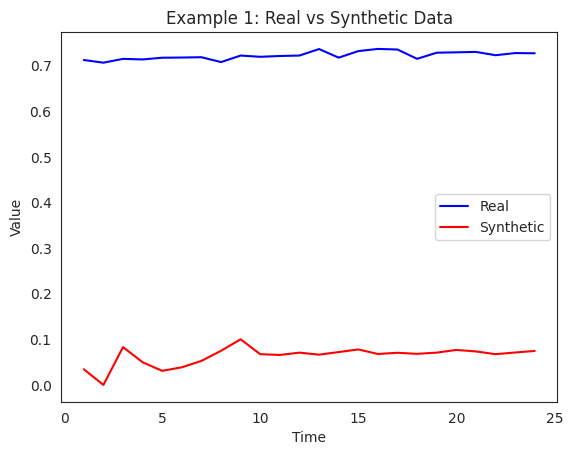

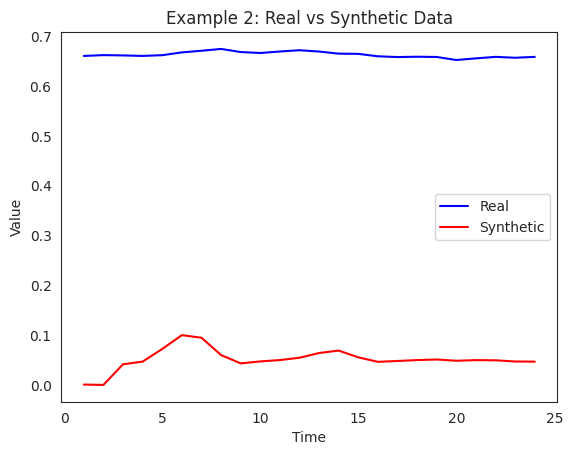

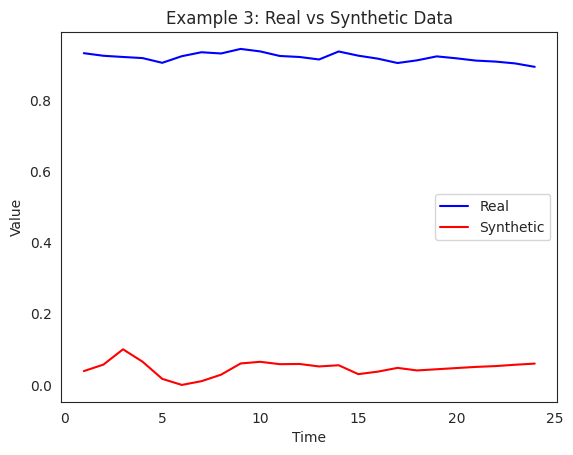

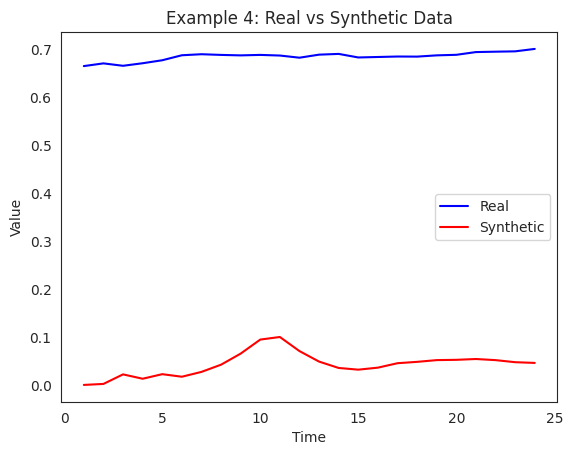

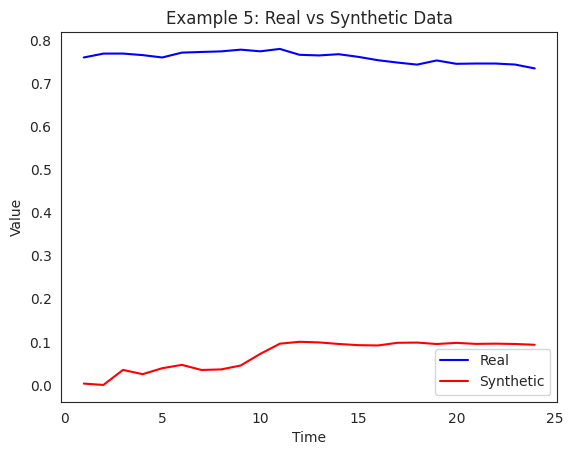

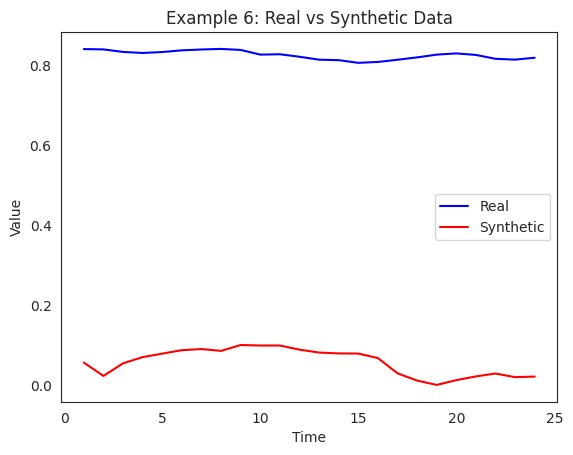

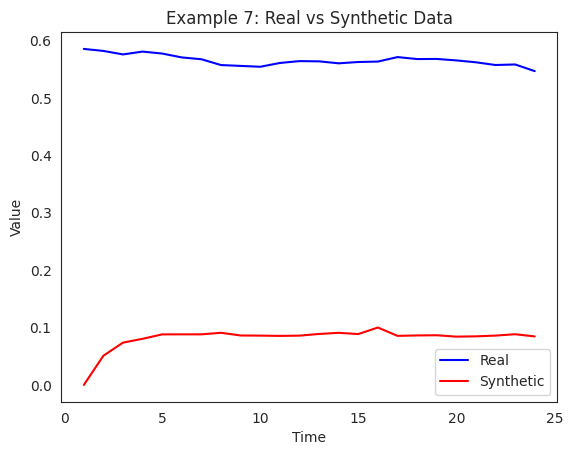

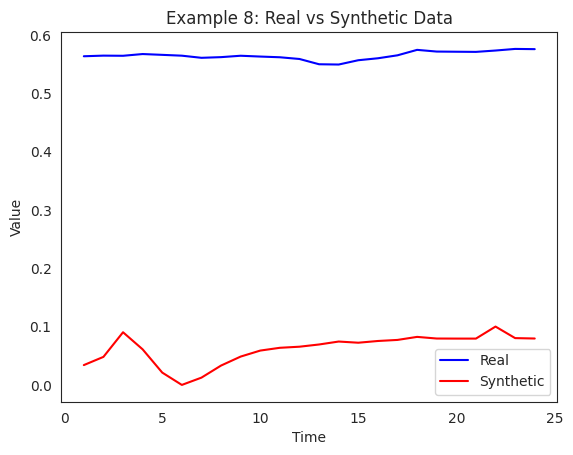

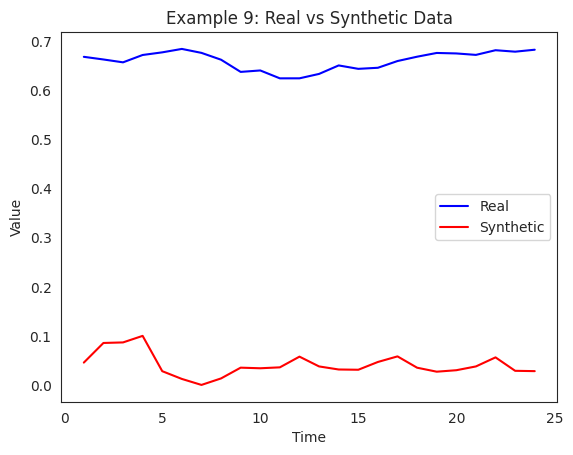

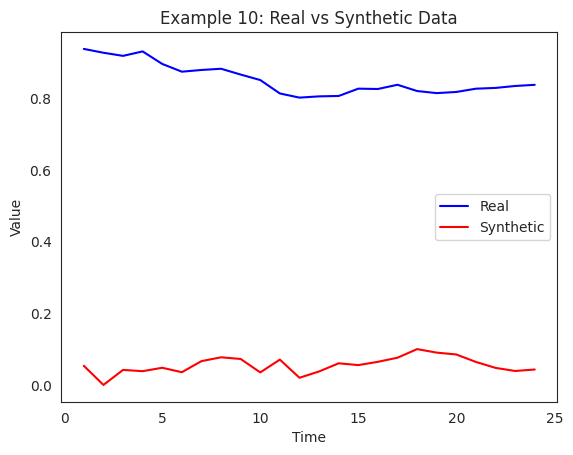

In [125]:
index = list(range(1, 25))

for i in range(10):
    plt.figure()
    
    synthetic = generated_data[np.random.randint(n_windows)]

    idx = np.random.randint(len(df_asset_1) - seq_len)
    real = pd.DataFrame(scaled_df_asset1).iloc[idx: idx + seq_len]

    scaled_synthetic = scaler.fit_transform(synthetic).astype(np.float32)

    plt.plot(index, real, label='Real', color='blue')
    plt.plot(index, scaled_synthetic/10, label='Synthetic', color='red')

    plt.legend()

    plt.title(f'Example {i+1}: Real vs Synthetic Data')
    plt.xlabel('Time')
    plt.ylabel('Value')

    plt.show()

